In [ ]:
#skip this block is already installed

!pip install xgboost
!pip install lightgbm
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [14]:
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut

from matplotlib import pyplot
from xgboost import plot_importance

color = sns.color_palette()

sys.path.insert(0,"/Users/fellipeferreira/OneDrive/CIT - Master Data Science/Semester 3/project/final-project-datascience-mtu/code/")  # path contains python_file.py
import utils
from utils import get_name_from_value
from utils import Target

In [15]:
print(Target(0).name)
print(Target(1).name)
get_name_from_value("1.0")

CONTROL
PATIENT


'PATIENT'

In [16]:
#PATH_TO_FILE = "../../psykose/schizophrenia-features.csv"

#my baseline features
PATH_TO_FILE = "../baseline_time_period.csv"

_PARAMS_LORGREG = {
    "penalty": "l2", "C": 1.0, "class_weight": "balanced",
    "random_state": 2018, "solver": "liblinear", "n_jobs": 1
}

_PARAMS_RFC = {
    "n_estimators": 10,
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, "bootstrap": True,
    "oob_score": False, "n_jobs": -1, "random_state": 2018,
    "class_weight": "balanced"
}

_PARAMS_DTC = {
    
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, 
     "random_state": 2018,
    "class_weight": "balanced"
    
}

_PARAMS_XGB = {
    "nthread":16, "learning_rate": 0.3, "gamma": 0, "max_depth": 6, "verbosity": 0,
    "min_child_weight": 1, "max_delta_step": 0, "subsample": 1.0, "colsample_bytree": 1.0,
    "objective":"binary:logistic", "num_class":1, "eval_metric":"logloss", "seed":2018,
}

_PARAMS_LIGHTGB = {
    "task": "train", "num_class":1, "boosting": "gbdt", "verbosity": -1,
    "objective": "binary", "metric": "binary_logloss", "metric_freq":50, "is_training_metric":False,
    "max_depth":4, "num_leaves": 31, "learning_rate": 0.01, "feature_fraction": 1.0, "bagging_fraction": 1.0,
    "bagging_freq": 0, "bagging_seed": 2018, "num_threads":16
}

# Data Frame to collect all results of the classifiers
df_result = pd.DataFrame()
df_feature_importance = pd.DataFrame()
df_leave_one_out = pd.DataFrame()

In [17]:
data = pd.read_csv(PATH_TO_FILE)

dataX = data.copy().drop(["class", "class_str", "userid"], axis=1)
dataY = data["class"].copy()

scaler = pp.StandardScaler(copy=True)

dataX.loc[:, dataX.columns] = scaler.fit_transform(dataX[dataX.columns])


testset_size = 0.5

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    dataX,
    dataY,
    test_size=testset_size,
    random_state=2019,
    stratify=dataY
)

In [18]:
def plot_prc_curve(y_preds, y_trues, title=None):
    
    precision, recall, _ = metrics.precision_recall_curve(
        y_trues,
        y_preds
    )

    average_precision = metrics.average_precision_score(
        y_trues,
        y_preds
    )

    print("Average Precision = %.2f" % average_precision)
    
    plt.step(recall, precision, color="k", alpha=0.7, where="post")
    plt.fill_between(recall, precision, step="post", alpha=0.3, color="k")

    if title is None:
        title = "PRC: Average Precision = %.2f" % average_precision

    plt.title(title)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.show()
    
    return average_precision

def plot_roc_curve(y_preds, y_trues, title=None):
    
    fpr, tpr, _ = metrics.roc_curve(y_trues, y_preds)

    auc_roc = metrics.auc(fpr, tpr)

    print("AUCROC = %.2f" % auc_roc)

    if title is None:
        title = "AUCROC = %.2f" % auc_roc

    plt.title(title)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
    plt.plot(fpr, tpr, color="r", lw=2, label="ROC curve")
    plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")

    plt.show()
    
    return auc_roc


def model_predict_k_fold( train_func, pred_func, model=None, n_splits=10, shuffle=True, random_state=2018 ):
     
    y_preds = []
    y_trues = []

    k_fold = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index, :], X_TRAIN.iloc[fold_index, :]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = train_func( model, x_fold_train, y_fold_train, x_fold_test, y_fold_test )
        y_pred = pred_func( model, x_fold_test )

        y_preds.extend( list(y_pred) )
        y_trues.extend( list(y_fold_test) )

    return model, np.array(y_preds), np.array(y_trues)


def leave_one_out(train_func, pred_func, model=None):
    y_preds = []
    y_trues = []

    loo = LeaveOneOut()

    for train_index, fold_index in loo.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index, :], X_TRAIN.iloc[fold_index, :]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = train_func(model, x_fold_train, y_fold_train, x_fold_test, y_fold_test)
        y_pred = pred_func(model, x_fold_test)

        y_preds.extend(list(y_pred))
        y_trues.extend(list(y_fold_test))

    return model, np.array(y_preds), np.array(y_trues)





# Logistic Regression

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       201
         1.0       0.85      0.89      0.87       142

    accuracy                           0.89       343
   macro avg       0.88      0.89      0.89       343
weighted avg       0.89      0.89      0.89       343

CONTROL
PATIENT
macro avg
weighted avg
Average Precision = 0.91


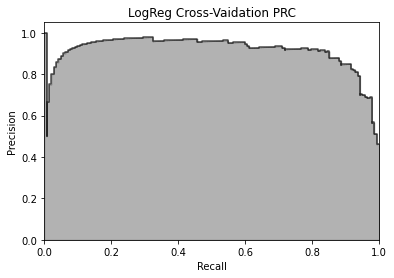

AUCROC = 0.95


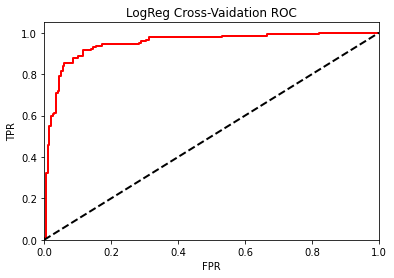

Average Precision = 0.88


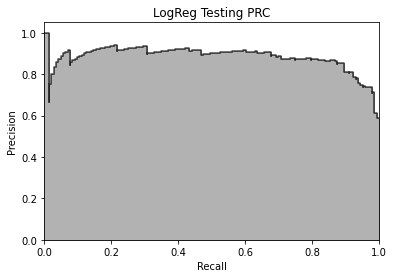

AUCROC = 0.94


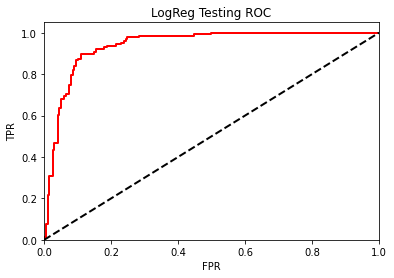

Feature: 0, Score: 0.60750
Feature: 1, Score: -0.95185
Feature: 2, Score: 0.05094
Feature: 3, Score: 0.31485
Feature: 4, Score: -0.57986
Feature: 5, Score: -0.47383
Feature: 6, Score: -0.65010
Feature: 7, Score: 0.48824
Feature: 8, Score: 0.65434
Feature: 9, Score: -0.83455
Feature: 10, Score: -0.54653
Feature: 11, Score: 0.76978
Feature: 12, Score: 0.72057
Feature: 13, Score: 0.09980
Feature: 14, Score: 1.08412
Feature: 15, Score: 0.15725
Feature: 16, Score: 0.40244
Feature: 17, Score: -0.14792
Feature: 18, Score: 0.18304
Feature: 19, Score: -1.38522
Feature: 20, Score: 1.84257
Feature: 21, Score: 0.12546
Feature: 22, Score: -0.04174
Feature: 23, Score: 0.92551
Feature: 24, Score: 0.45606
Feature: 25, Score: 0.44759
Feature: 26, Score: -0.36172


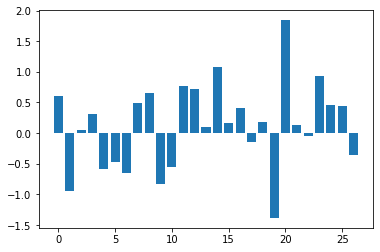

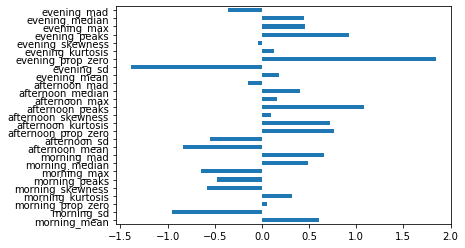

In [19]:
def logreg_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def logreg_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

logreg = LogisticRegression( **_PARAMS_LORGREG )

logreg, logreg_y_preds, logreg_y_trues = model_predict_k_fold( logreg_train_func, logreg_pred_func, logreg )
logreg_test_preds = logreg_pred_func( logreg, X_TEST )


#Leave one out
logreg_loo = LogisticRegression(**_PARAMS_LORGREG)
logreg_loo, logreg_y_preds_loo, logreg_y_trues_loo = leave_one_out( logreg_train_func, logreg_pred_func, logreg_loo )

print(classification_report(logreg_y_trues_loo, logreg_y_preds_loo.round()))
dict_report = classification_report(logreg_y_trues_loo, logreg_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "Logistic Regression" }
    if isinstance(value, dict):
        print(get_name_from_value(key))
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )





#precision-recall curves (PRC)
#Receiver-operator curves (ROC)
average_precision = plot_prc_curve( logreg_y_preds, logreg_y_trues, "LogReg Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( logreg_y_preds, logreg_y_trues, "LogReg Cross-Vaidation ROC" )

plot_prc_curve( logreg_test_preds, Y_TEST, "LogReg Testing PRC" )
plot_roc_curve( logreg_test_preds, Y_TEST, "LogReg Testing ROC" )


#collect the result
row_stats = {'classifier': "Logistic Regression", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )

# get importance
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

(pd.Series(logreg.coef_[0], index=X_TRAIN.columns)
  # .nlargest(4)
   .plot(kind='barh'))


series_features = pd.Series(logreg.coef_[0], index=X_TRAIN.columns)
row_features = {'classifier': "Logistic Regression"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# Random Forest

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       201
         1.0       0.85      0.82      0.84       142

    accuracy                           0.87       343
   macro avg       0.87      0.86      0.86       343
weighted avg       0.87      0.87      0.87       343

Average Precision = 0.90


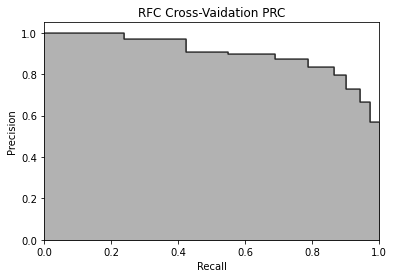

AUCROC = 0.94


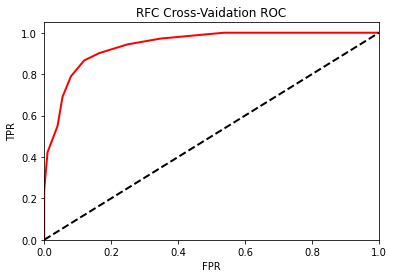

Average Precision = 0.85


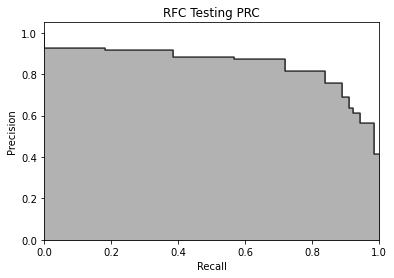

AUCROC = 0.91


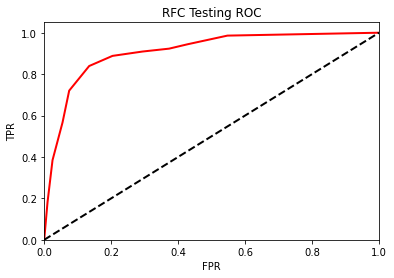

Feature: 0, Score: 0.01655
Feature: 1, Score: 0.01292
Feature: 2, Score: 0.02630
Feature: 3, Score: 0.02436
Feature: 4, Score: 0.01368
Feature: 5, Score: 0.03955
Feature: 6, Score: 0.01782
Feature: 7, Score: 0.00533
Feature: 8, Score: 0.00371
Feature: 9, Score: 0.07145
Feature: 10, Score: 0.11143
Feature: 11, Score: 0.00789
Feature: 12, Score: 0.01504
Feature: 13, Score: 0.00878
Feature: 14, Score: 0.03778
Feature: 15, Score: 0.07449
Feature: 16, Score: 0.01089
Feature: 17, Score: 0.01600
Feature: 18, Score: 0.17658
Feature: 19, Score: 0.09145
Feature: 20, Score: 0.06553
Feature: 21, Score: 0.01854
Feature: 22, Score: 0.01619
Feature: 23, Score: 0.01456
Feature: 24, Score: 0.04681
Feature: 25, Score: 0.03520
Feature: 26, Score: 0.02118


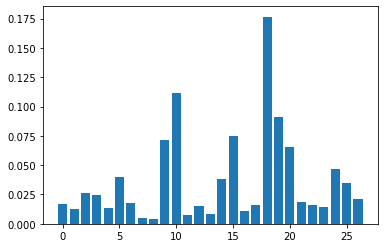

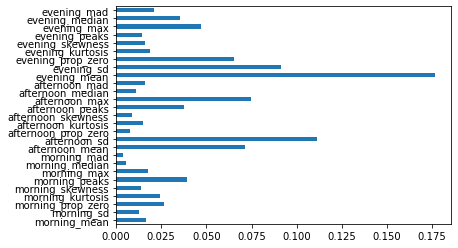

In [20]:
def rfc_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def rfc_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

rfc = RandomForestClassifier( **_PARAMS_RFC )

rfc, rfc_y_preds, rfc_y_trues = model_predict_k_fold( rfc_train_func, rfc_pred_func, rfc )
rfc_test_preds = rfc_pred_func( rfc, X_TEST )


#Leave one out
rfc_loo = RandomForestClassifier(**_PARAMS_RFC)
rfc_loo, rfc_y_preds_loo, rfc_y_trues_loo = leave_one_out( logreg_train_func, logreg_pred_func, rfc_loo )
print(classification_report(rfc_y_trues_loo, rfc_y_preds_loo.round()))

dict_report = classification_report(rfc_y_trues_loo, rfc_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "Random Forest" }
    if isinstance(value, dict):
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )



average_precision = plot_prc_curve( rfc_y_preds, rfc_y_trues, "RFC Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( rfc_y_preds, rfc_y_trues, "RFC Cross-Vaidation ROC" )

plot_prc_curve( rfc_test_preds, Y_TEST, "RFC Testing PRC" )
plot_roc_curve( rfc_test_preds, Y_TEST, "RFC Testing ROC" )



#collect the result
row_stats = {'classifier': "Random Forest", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# get importance
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#
(pd.Series(importance, index=X_TRAIN.columns)
   #.nlargest(4)
   .plot(kind='barh'))



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "Random Forest"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)


# Decision Tree



              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       201
         1.0       0.85      0.82      0.84       142

    accuracy                           0.87       343
   macro avg       0.87      0.86      0.86       343
weighted avg       0.87      0.87      0.87       343

Average Precision = 0.68


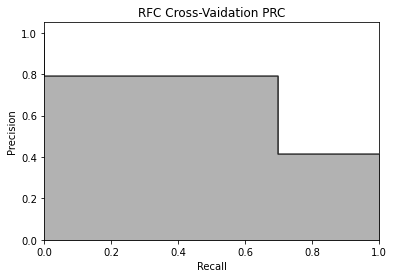

AUCROC = 0.78


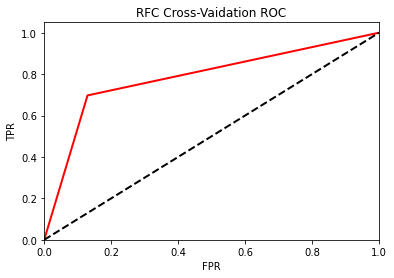

Average Precision = 0.71


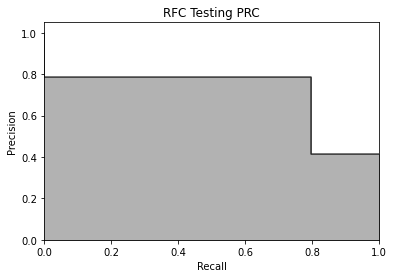

AUCROC = 0.82


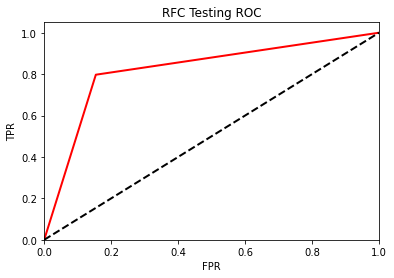

Feature: 0, Score: 0.01655
Feature: 1, Score: 0.01292
Feature: 2, Score: 0.02630
Feature: 3, Score: 0.02436
Feature: 4, Score: 0.01368
Feature: 5, Score: 0.03955
Feature: 6, Score: 0.01782
Feature: 7, Score: 0.00533
Feature: 8, Score: 0.00371
Feature: 9, Score: 0.07145
Feature: 10, Score: 0.11143
Feature: 11, Score: 0.00789
Feature: 12, Score: 0.01504
Feature: 13, Score: 0.00878
Feature: 14, Score: 0.03778
Feature: 15, Score: 0.07449
Feature: 16, Score: 0.01089
Feature: 17, Score: 0.01600
Feature: 18, Score: 0.17658
Feature: 19, Score: 0.09145
Feature: 20, Score: 0.06553
Feature: 21, Score: 0.01854
Feature: 22, Score: 0.01619
Feature: 23, Score: 0.01456
Feature: 24, Score: 0.04681
Feature: 25, Score: 0.03520
Feature: 26, Score: 0.02118


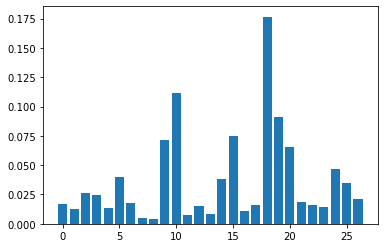

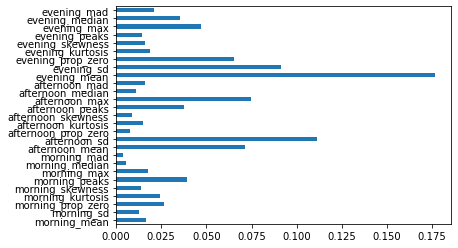

In [21]:
from sklearn.tree import DecisionTreeClassifier

def dtc_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def dtc_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

dtc = DecisionTreeClassifier( **_PARAMS_DTC )

dtc, dtc_y_preds, dtc_y_trues = model_predict_k_fold( dtc_train_func, dtc_pred_func, dtc )
dtc_test_preds = dtc_pred_func( dtc, X_TEST )


#Leave one out
dtc_loo = RandomForestClassifier(**_PARAMS_RFC)
dtc_loo, dtc_y_preds_loo, dtc_y_trues_loo = leave_one_out( logreg_train_func, logreg_pred_func, dtc_loo )
print(classification_report(dtc_y_trues_loo, dtc_y_preds_loo.round()))

dict_report = classification_report(dtc_y_trues_loo, dtc_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "Decision Tree" }
    if isinstance(value, dict):
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )



average_precision = plot_prc_curve( dtc_y_preds, dtc_y_trues, "RFC Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( dtc_y_preds, dtc_y_trues, "RFC Cross-Vaidation ROC" )

plot_prc_curve( dtc_test_preds, Y_TEST, "RFC Testing PRC" )
plot_roc_curve( dtc_test_preds, Y_TEST, "RFC Testing ROC" )



#collect the result
row_stats = {'classifier': "Decision Tree", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# get importance
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#
(pd.Series(importance, index=X_TRAIN.columns)
   #.nlargest(4)
   .plot(kind='barh'))



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "Decision Tree"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# XGBoost

[0]	train-logloss:0.49792+0.00675	test-logloss:0.55781+0.01868
[50]	train-logloss:0.01762+0.00072	test-logloss:0.30118+0.10080
[100]	train-logloss:0.01299+0.00022	test-logloss:0.30998+0.10460
[150]	train-logloss:0.01174+0.00027	test-logloss:0.31630+0.10563
[200]	train-logloss:0.01086+0.00030	test-logloss:0.32510+0.11289
[226]	train-logloss:0.01050+0.00029	test-logloss:0.32873+0.11565
[0]	train-logloss:0.49944+0.00315	test-logloss:0.56246+0.02828
[50]	train-logloss:0.01756+0.00075	test-logloss:0.36715+0.12036
[100]	train-logloss:0.01304+0.00040	test-logloss:0.39192+0.14743
[150]	train-logloss:0.01183+0.00043	test-logloss:0.40742+0.16385
[200]	train-logloss:0.01104+0.00043	test-logloss:0.42004+0.17769
[211]	train-logloss:0.01090+0.00043	test-logloss:0.42227+0.18030
[0]	train-logloss:0.50135+0.00309	test-logloss:0.54965+0.02774
[50]	train-logloss:0.01818+0.00049	test-logloss:0.34180+0.10300
[100]	train-logloss:0.01339+0.00027	test-logloss:0.36063+0.11315
[150]	train-logloss:0.01209+0.0002

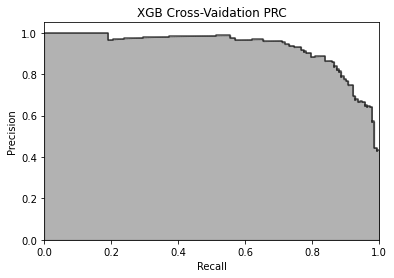

AUCROC = 0.94


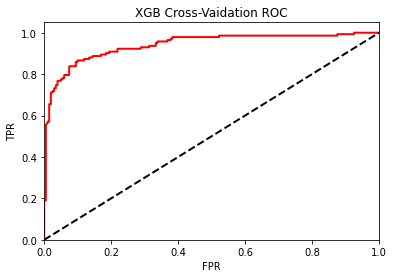

Average Precision = 0.92


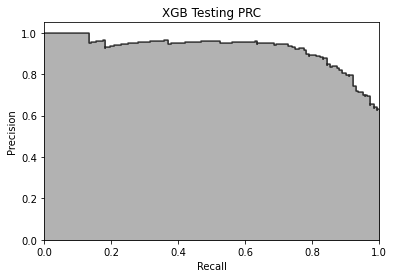

AUCROC = 0.95


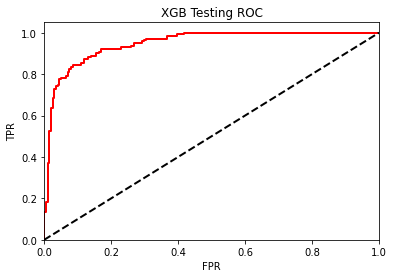

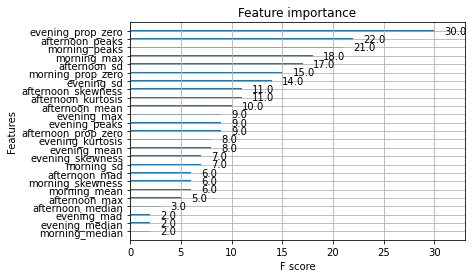

In [22]:
def xgb_train_func(model, x_train, y_train, x_test, y_test):
    dtrain = xgb.DMatrix(data=x_train, label=y_train)

    bst = xgb.cv(_PARAMS_XGB,
        dtrain,
        num_boost_round=2000,
        nfold=5,
        early_stopping_rounds=200,
        verbose_eval=50
    )

    best_rounds = np.argmin(bst["test-logloss-mean"])
    bst = xgb.train(_PARAMS_XGB, dtrain, best_rounds)
    return bst

def xgb_pred_func(model, data):
    data = xgb.DMatrix(data=data)
    pred = model.predict(data)
    return pred

xgb_model, xgb_y_preds, xgb_y_trues = model_predict_k_fold( xgb_train_func, xgb_pred_func )
xgb_test_preds = xgb_pred_func( xgb_model, X_TEST )

average_precision = plot_prc_curve( xgb_y_preds, xgb_y_trues, "XGB Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( xgb_y_preds, xgb_y_trues, "XGB Cross-Vaidation ROC" )

plot_prc_curve( xgb_test_preds, Y_TEST, "XGB Testing PRC" )
plot_roc_curve( xgb_test_preds, Y_TEST, "XGB Testing ROC" )



#collect the result
row_stats = {'classifier': "XGBoot", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# plot feature importance
plot_importance(xgb_model)
pyplot.show()



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "XGBoost"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# LightGBM

Average Precision = 0.96


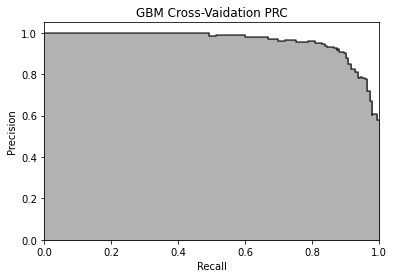

AUCROC = 0.97


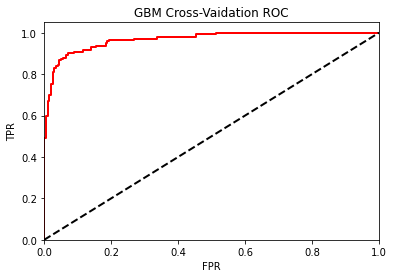

Average Precision = 0.93


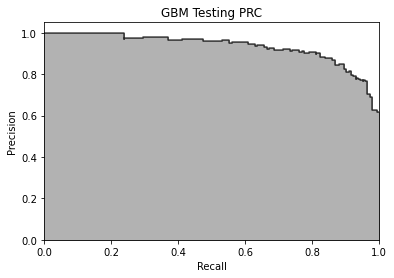

AUCROC = 0.95


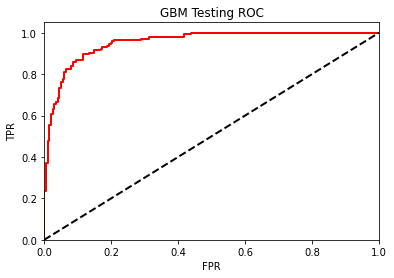

Plotting feature importances...


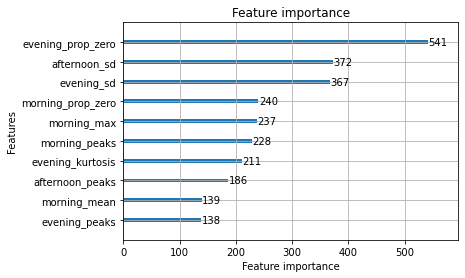

In [23]:
def gbm_train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    gbm = lgb.train(
        _PARAMS_LIGHTGB,
        lgb_train,
        verbose_eval=False,
        num_boost_round=2000,
        valid_sets=lgb_eval,
        early_stopping_rounds=200
    )

    return gbm

def gbm_pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)

gbm, gbm_y_preds, gbm_y_trues = model_predict_k_fold( gbm_train_func, gbm_pred_func )
gbm_test_preds = gbm_pred_func( gbm, X_TEST )

average_precision = plot_prc_curve( gbm_y_preds, gbm_y_trues, "GBM Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( gbm_y_preds, gbm_y_trues, "GBM Cross-Vaidation ROC" )

plot_prc_curve( gbm_test_preds, Y_TEST, "GBM Testing PRC" )
plot_roc_curve( gbm_test_preds, Y_TEST, "GBM Testing ROC" )




#collect the result
row_stats = {'classifier': "LightGBM", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()



df_feature_importance_2 = (
    pd.DataFrame({
        'feature': gbm.feature_name(),
        'importance': gbm.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)

series_features = pd.Series(gbm.feature_importance(), index=gbm.feature_name())
row_features = {'classifier': "LightGBM"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# Ensemble

Average Precision = 0.96


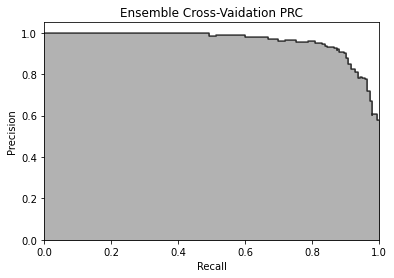

AUCROC = 0.97


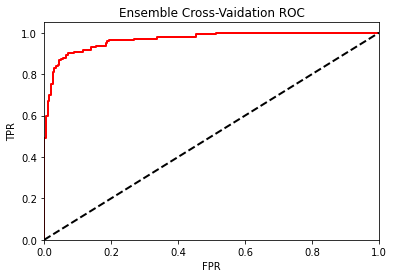

Average Precision = 0.93


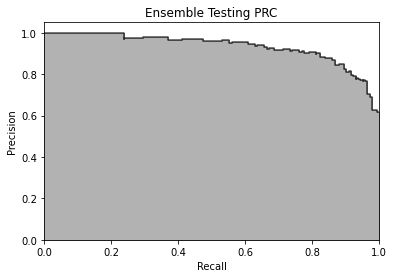

AUCROC = 0.95


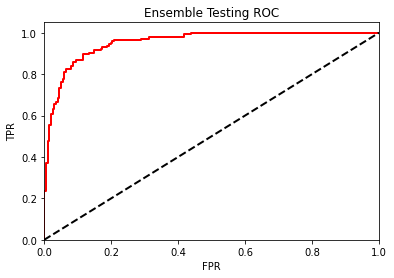

Plotting feature importances...


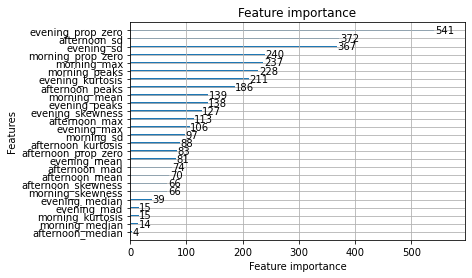

In [24]:
def ensemble_train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    ensemble = lgb.train(
        _PARAMS_LIGHTGB,
        lgb_train,
        verbose_eval=False,
        num_boost_round=2000,
        valid_sets=lgb_eval,
        early_stopping_rounds=200
    )

    return ensemble

def ensemble_pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)

ensemble, ensemble_y_preds, ensemble_y_trues = model_predict_k_fold( ensemble_train_func, ensemble_pred_func )
ensemble_test_preds = ensemble_pred_func( ensemble, X_TEST )

average_precision = plot_prc_curve( ensemble_y_preds, ensemble_y_trues, "Ensemble Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( ensemble_y_preds, ensemble_y_trues, "Ensemble Cross-Vaidation ROC" )

plot_prc_curve( ensemble_test_preds, Y_TEST, "Ensemble Testing PRC" )
plot_roc_curve( ensemble_test_preds, Y_TEST, "Ensemble Testing ROC" )


#collect the result
row_stats = {'classifier': "Ensemble", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )



print('Plotting feature importances...')
ax = lgb.plot_importance(ensemble)
plt.show()




series_features = pd.Series(ensemble.feature_importance(), index=ensemble.feature_name())
row_features = {'classifier': "Ensemble"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)


In [14]:
df_result = df_result[['classifier', 'Average Precision', 'AUCROC', 'testset_size']]
df_result


,classifier,Average Precision,AUCROC,testset_size
0,Logistic Regression,0.914541,0.937355,0.5
1,Random Forest,0.859989,0.913005,0.5
2,XGBoot,0.928329,0.942085,0.5
3,LightGBM,0.949978,0.959183,0.5
4,Ensemble,0.949978,0.959183,0.5


In [15]:
#df_feature_importance = df_feature_importance[['classifier', 'mean', 'sd', 'prop_zero', 'kurtosis', 'skew']]
#df_feature_importance = df_feature_importance[['classifier', 'mean', 'sd', 'prop_zero']]
df_feature_importance

,afternoon_kurtosis,afternoon_mean,afternoon_prop_zero,afternoon_sd,afternoon_skewness,classifier,evening_kurtosis,evening_mean,evening_prop_zero,evening_sd,evening_skewness,morning_kurtosis,morning_mean,morning_prop_zero,morning_sd,morning_skewness
0,0.984722,0.648944,0.411228,-1.614072,-0.149704,Logistic Regression,-0.225387,0.815214,1.485514,-1.398185,-0.029793,0.112705,0.736065,-0.142280,-1.779904,0.020729
1,0.048393,0.097586,0.059082,0.139650,0.037515,Random Forest,0.043697,0.089672,0.128365,0.135714,0.020860,0.031206,0.036105,0.053069,0.052303,0.026784
2,0.048393,0.097586,0.059082,0.139650,0.037515,XGBoost,0.043697,0.089672,0.128365,0.135714,0.020860,0.031206,0.036105,0.053069,0.052303,0.026784
3,202.000000,72.000000,285.000000,367.000000,55.000000,LightGBM,112.000000,126.000000,628.000000,546.000000,224.000000,103.000000,103.000000,432.000000,427.000000,249.000000
4,202.000000,72.000000,285.000000,367.000000,55.000000,Ensemble,112.000000,126.000000,628.000000,546.000000,224.000000,103.000000,103.000000,432.000000,427.000000,249.000000


In [40]:
df_leave_one_out = df_leave_one_out[['Classifier', 'Class', 'precision', 'recall', 'f1-score', 'support']]
df_leave_one_out

,Classifier,Class,precision,recall,f1-score,support
0,Logistic Regression,CONTROL,0.936508,0.880597,0.907692,201.0
1,Logistic Regression,PATIENT,0.844156,0.915493,0.878378,142.0
2,Logistic Regression,macro avg,0.890332,0.898045,0.893035,343.0
3,Logistic Regression,weighted avg,0.898275,0.895044,0.895557,343.0
4,Random Forest,CONTROL,0.841121,0.895522,0.867470,201.0
5,Random Forest,PATIENT,0.837209,0.760563,0.797048,142.0
6,Random Forest,macro avg,0.839165,0.828043,0.832259,343.0
7,Random Forest,weighted avg,0.839502,0.839650,0.838316,343.0
8,Decision Tree,CONTROL,0.841121,0.895522,0.867470,201.0
9,Decision Tree,PATIENT,0.837209,0.760563,0.797048,142.0


In [ ]:
#with number of peaks for each period of time 

In [12]:
#k-fold validation
df_result = df_result[['classifier', 'Average Precision', 'AUCROC', 'testset_size']]
df_result

,classifier,Average Precision,AUCROC,testset_size
0,Logistic Regression,0.932656,0.953192,0.5
1,Random Forest,0.845964,0.912778,0.5
2,Decision Tree,0.639739,0.766695,0.5
3,XGBoot,0.897204,0.941420,0.5
4,LightGBM,0.936629,0.953052,0.5
5,Ensemble,0.936629,0.953052,0.5


In [13]:
#leave one-out
df_leave_one_out = df_leave_one_out[['Classifier', 'Class', 'precision', 'recall', 'f1-score', 'support']]
df_leave_one_out

,Classifier,Class,precision,recall,f1-score,support
0,Logistic Regression,CONTROL,0.921875,0.880597,0.900763,201.0
1,Logistic Regression,PATIENT,0.841060,0.894366,0.866894,142.0
2,Logistic Regression,macro avg,0.881467,0.887482,0.883829,343.0
3,Logistic Regression,weighted avg,0.888418,0.886297,0.886742,343.0
4,Random Forest,CONTROL,0.841121,0.895522,0.867470,201.0
5,Random Forest,PATIENT,0.837209,0.760563,0.797048,142.0
6,Random Forest,macro avg,0.839165,0.828043,0.832259,343.0
7,Random Forest,weighted avg,0.839502,0.839650,0.838316,343.0
8,Decision Tree,CONTROL,0.841121,0.895522,0.867470,201.0
9,Decision Tree,PATIENT,0.837209,0.760563,0.797048,142.0


In [ ]:
#with number of peaks and max value

In [13]:
#k-fold validation
df_result = df_result[['classifier', 'Average Precision', 'AUCROC', 'testset_size']]
df_result

,classifier,Average Precision,AUCROC,testset_size
0,Logistic Regression,0.904482,0.940754,0.5
1,Random Forest,0.888598,0.932223,0.5
2,Decision Tree,0.695868,0.814344,0.5
3,XGBoot,0.939431,0.956100,0.5
4,LightGBM,0.968666,0.973863,0.5
5,Ensemble,0.968666,0.973863,0.5


In [12]:
#leave one-out
df_leave_one_out = df_leave_one_out[['Classifier', 'Class', 'precision', 'recall', 'f1-score', 'support']]
df_leave_one_out

,Classifier,Class,precision,recall,f1-score,support
0,Logistic Regression,CONTROL,0.931579,0.880597,0.905371,201.0
1,Logistic Regression,PATIENT,0.843137,0.908451,0.874576,142.0
2,Logistic Regression,macro avg,0.887358,0.894524,0.889974,343.0
3,Logistic Regression,weighted avg,0.894965,0.892128,0.892622,343.0
4,Random Forest,CONTROL,0.856481,0.920398,0.887290,201.0
5,Random Forest,PATIENT,0.874016,0.781690,0.825279,142.0
6,Random Forest,macro avg,0.865249,0.851044,0.856284,343.0
7,Random Forest,weighted avg,0.863741,0.862974,0.861618,343.0
8,Decision Tree,CONTROL,0.856481,0.920398,0.887290,201.0
9,Decision Tree,PATIENT,0.874016,0.781690,0.825279,142.0


In [ ]:
#all features
#including median and median absolute deviation

In [25]:
#k-fold validation
df_result = df_result[['classifier', 'Average Precision', 'AUCROC', 'testset_size']]
df_result

,classifier,Average Precision,AUCROC,testset_size
0,Logistic Regression,0.914757,0.948672,0.5
1,Random Forest,0.902769,0.940351,0.5
2,Decision Tree,0.677533,0.783915,0.5
3,XGBoot,0.930823,0.940947,0.5
4,LightGBM,0.960709,0.967557,0.5
5,Ensemble,0.960709,0.967557,0.5


In [26]:
#leave one-out
df_leave_one_out = df_leave_one_out[['Classifier', 'Class', 'precision', 'recall', 'f1-score', 'support']]
df_leave_one_out

,Classifier,Class,precision,recall,f1-score,support
0,Logistic Regression,CONTROL,0.922280,0.885572,0.903553,201.0
1,Logistic Regression,PATIENT,0.846667,0.894366,0.869863,142.0
2,Logistic Regression,macro avg,0.884473,0.889969,0.886708,343.0
3,Logistic Regression,weighted avg,0.890976,0.889213,0.889606,343.0
4,Random Forest,CONTROL,0.878641,0.900498,0.889435,201.0
5,Random Forest,PATIENT,0.854015,0.823944,0.838710,142.0
6,Random Forest,macro avg,0.866328,0.862221,0.864072,343.0
7,Random Forest,weighted avg,0.868446,0.868805,0.868435,343.0
8,Decision Tree,CONTROL,0.878641,0.900498,0.889435,201.0
9,Decision Tree,PATIENT,0.854015,0.823944,0.838710,142.0
